In [1]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt

C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\

In [35]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.distances import CosineDistance



In [2]:
encoded_latents = []
latents_dir = "./latent_representations/landscapes-no-cond/"
for filename in os.listdir(latents_dir):
    latent = np.load(latents_dir + filename)
    encoded_latents.append(latent)
encoded_latents_avg = [np.mean(x, axis=0) for x in encoded_latents]


In [38]:
# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 3)
# Create engine with pipeline configuration
engine = Engine(encoded_latents_avg[0].shape[0], lshashes=[rbp], distance=CosineDistance())

for i,v in enumerate(encoded_latents_avg):
    engine.store_vector(v, 'data_%d' % i)


In [16]:
directory = 'results/vm/landscapes-no-cond/'
fn = 'network-snapshot-006126.pkl'
rnd = np.random.RandomState(0)

# Initialize TensorFlow
tflib.init_tf()
_G, _D, Gs = pickle.load(open(os.path.join(directory, fn), 'rb'))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
qlatents = rnd.randn(10, Gs.input_shape[1])
dlatents = Gs.components.mapping.run(qlatents, None)


In [39]:
query = np.mean(dlatents[3], axis=0)
# Get nearest neighbours
N = engine.neighbours(query)
N

[(array([-5.11652087e-02,  3.24173373e-02,  1.24262919e-02,  6.35624569e-03,
          2.48830546e-02,  1.23040170e-02,  1.78820953e-02,  2.75666414e-02,
         -9.26295192e-04,  4.76573240e-02, -4.98704162e-02,  2.57133494e-02,
          8.72252572e-03, -5.18680705e-02, -1.82849949e-02,  4.56444158e-02,
          3.04608801e-02,  9.72193513e-03,  9.59447785e-02,  1.77245074e-03,
         -5.58227747e-02,  3.58041441e-02, -8.71523848e-03, -2.98781911e-02,
          2.25055236e-02,  6.77562283e-02, -7.20996277e-03,  1.00818828e-02,
         -1.39788251e-02,  1.02497315e-02,  2.43015442e-03,  4.42547317e-02,
          6.75308934e-02,  3.81763619e-02,  4.63085787e-02, -1.00684153e-03,
          3.33429144e-02,  7.00252006e-02,  1.71571569e-02, -3.86412525e-02,
         -3.78876165e-03, -5.61044065e-02, -3.19606271e-02,  9.43050729e-02,
          1.41484579e-02, -4.91154030e-02,  5.14750507e-03,  6.41580925e-02,
          1.20062962e-01, -2.06171052e-02,  2.97646489e-02, -2.48883309e-02,

In [42]:
dists = CosineDistance().distance(encoded_latents_avg,query)

In [43]:
dists

array([-1.3705909 , -1.6292996 , -1.4212279 , -2.1625679 , -0.63286114,
       -1.7091975 , -0.98729897, -1.7118838 , -1.644218  , -1.8567958 ],
      dtype=float32)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
cosine_similarity(encoded_latents_avg,[query])

array([[0.2222796 ],
       [0.24322803],
       [0.21696305],
       [0.2861957 ],
       [0.1497254 ],
       [0.25685585],
       [0.17934188],
       [0.24451369],
       [0.2464084 ],
       [0.27334514]], dtype=float32)

In [3]:
encoded_latents = []
latents_dir = "./latent_representations/landscapes-no-cond/"
for filename in os.listdir(latents_dir):
    latent = np.load(latents_dir + filename)
    encoded_latents.append(latent)
encoded_latents_avg = [np.mean(x, axis=0) for x in encoded_latents]

In [4]:

def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, latent_vector.shape[0], 512))
    synthesis_kwargs = dict(output_transform=dict(
        func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)
    images = Gs.components.synthesis.run(
        latent_vector, randomize_noise=False, **synthesis_kwargs)
    img = PIL.Image.fromarray(images[0], 'RGB')
    return img  # .resize((256, 256))

In [16]:

def generate_image2(latent_vector):
    latent_vector = latent_vector.reshape((1, latent_vector.shape[0], 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    #avg_latents.append(generator.get_dlatent_avg())
    return img.resize((256, 256))

In [7]:
dir = 'results/vm/landscapes-no-cond/'
fn = 'network-snapshot-006126.pkl'

# Initialize TensorFlow
tflib.init_tf()
_G, _D, Gs = pickle.load(open(os.path.join(dir, fn), 'rb'))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
from encoder.generator_model import Generator

In [11]:
generator = Generator(Gs, 1, clipping_threshold=2.0, tiled_dlatent=False,
                      model_res=512, randomize_noise=False)

In [8]:
num = 0
rnd = np.random.RandomState(num)

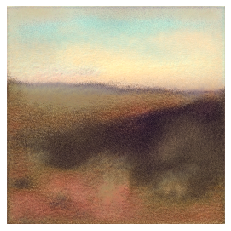

In [19]:
plt.imshow(generate_image(encoded_latents[0]))
plt.axis('off')
plt.show()

In [21]:
plt.imshow(generate_image2(encoded_latents[0]))
plt.axis('off')
plt.show()

InvalidArgumentError: You must feed a value for placeholder tensor 'G_synthesis_1/_Run/dlatents_in' with dtype float
	 [[node G_synthesis_1/_Run/dlatents_in (defined at C:\Users\olivi\Documents\COMP4906\stylegan\dnnlib\tflib\network.py:440) ]]

Original stack trace for 'G_synthesis_1/_Run/dlatents_in':
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-707c0a941959>", line 1, in <module>
    plt.imshow(generate_image(encoded_latents[0]))
  File "<ipython-input-4-7597d6623dd7>", line 6, in generate_image
    latent_vector, randomize_noise=False, **synthesis_kwargs)
  File "C:\Users\olivi\Documents\COMP4906\stylegan\dnnlib\tflib\network.py", line 440, in run
    in_expr = [tf.placeholder(tf.float32, name=name) for name in self.input_names]
  File "C:\Users\olivi\Documents\COMP4906\stylegan\dnnlib\tflib\network.py", line 440, in <listcomp>
    in_expr = [tf.placeholder(tf.float32, name=name) for name in self.input_names]
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 7401, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\olivi\Anaconda3\envs\tf1-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [27]:
np.mean([encoded_latents[0],encoded_latents[1]], axis=0).shape

(16, 512)